In [2]:
#using Plots
using CairoMakie
using RollingFunctions
using ProgressMeter
using LinearAlgebra
using DelaunayTriangulation
using DelimitedFiles
using MPI
include("Compass.jl")

main (generic function with 1 method)

In [3]:
function projection(point; origin=[1 / 3, 1 / 3, 1 / 3], e1=normalize(cross(normalize([0.0, 0.0, 1.0] .- [1 / 3, 1 / 3, 1 / 3]), normalize([1 / 3, 1 / 3, 1 / 3]))), e2=normalize([0.0, 0.0, 1.0] .- [1 / 3, 1 / 3, 1 / 3]))
    return sum(e1 .* (point .- origin)), sum(e2 .* (point .- origin))
end

projection (generic function with 1 method)

In [4]:
function main(p, L; keep_result=false, phases=false, iterations = 300, thermalization = 1000)
    X,Y,Z = create_operators(L)
    N = L^2
    dist  = Distributions.Categorical([p[1],p[2],p[3]])
    Sx = []
    Sy = []
    Tx = []
    Ty = []
    state = MixedDestabilizer(zero(Stabilizer, N))
    
    #for i in length(X)
    #    project!(state, X[i], keep_result=false, phases=false)
    #end
    for i in 1:thermalization
        for j in 1:N
            xi = rand(1:L)
            yi = rand(1:L)

            ope = rand(dist)

            if ope == 1 #do X operation
                project!(state, X[xi,yi], keep_result=false, phases=false)
            elseif ope == 2 #do Y operation
                project!(state, Y[xi,yi], keep_result=false, phases=false)
            else #do Z operation
                yi = rand(1:Int(L/2))
                project!(state, Z[xi,yi], keep_result=false, phases=false)
            end
        end
    end
    for i in 1:iterations
        for j in 1:N
            xi = rand(1:L)
            yi = rand(1:L)

            ope = rand(dist)

            if ope == 1 #do X operation
                project!(state, X[xi,yi], keep_result=false, phases=false)
            elseif ope == 2 #do Y operation
                project!(state, Y[xi,yi], keep_result=false, phases=false)
            else #do Z operation
                yi = rand(1:Int(L/2))
                project!(state, Z[xi,yi], keep_result=false, phases=false)
            end

            push!(Sx, calc_EE(state, Int(L/2), L, "x"))
            push!(Sy, calc_EE(state, Int(L/2), L, "y"))
            push!(Tx, TMI(state, L, "x"))
            push!(Ty, TMI(state, L, "y"))
        end
    end

    return mean(Sx), mean(Sy), mean(Tx), mean(Ty)
end

main (generic function with 1 method)

In [136]:
pxs = []
pys = []
pzs = []

for z in range(0,1,step=0.05)
    for x in range(0,1-z,step=0.05)
        y = round(1 - x - z, digits=2)
        push!(pxs, x)
        push!(pys, y)
        push!(pzs, z)
    end
end

p = collect(zip(pxs,pys,pzs));

In [135]:
Sx = []
Sy = []
Tx = []
Ty = []

@showprogress for i in 1:228#length(pxs)
    sx, sy, tx, ty = main(p[i], 8)
    push!(Sx, sx)
    push!(Sy, sy)
    push!(Tx, tx)
    push!(Ty, ty)
end

InterruptException: InterruptException:

In [32]:
data_16 = readdlm("data/data_L16_2_SxSyTxTy.txt", '\t', Float64, '\n')
data_8 = readdlm("data/data_L8_2_SxSyTxTy.txt", '\t', Float64, '\n')

228×4 Matrix{Float64}:
  0.0     8.0      0.0      8.0
  0.2165  8.002    0.0      7.984
  1.458   6.016    0.0      5.971
  1.7535  5.031   -0.0005   4.958
  1.139   7.0705   0.0      6.863
  2.628   6.6565   0.846    6.098
  2.2035  8.048    0.0035   7.0005
  2.9565  8.3595  -0.0015   6.621
  5.0325  7.6295   1.0125   4.58
  6.5555  7.875    1.129    3.0085
  ⋮                        
  6.8865  7.8245   0.744    6.974
 14.415   3.213   -3.1255  -0.1255
 12.249   0.7535   1.631    0.0115
 12.029   0.0      4.013    0.0
  5.7225  7.896    0.0      7.298
 12.896   0.817    0.3385   0.022
  2.5295  4.408    0.0      1.4485
 11.999   0.0      3.994    0.0
  0.0     0.0      0.0      0.0

In [3]:
## ACHTUNG!!! "w" == write --> ALTES DOKUMENT WIRD GELÖSCHT!!
#=open("data/data_L8_2_SxSyTxTy.txt", "w") do io
    writedlm(io, St)
end

UndefVarError: UndefVarError: `ST` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [2]:
using MPI

In [24]:
using MPI
using DelimitedFiles
using ProgressMeter
include("Compass.jl")

MPI.Init()
comm = MPI.COMM_WORLD
rank = MPI.Comm_rank(comm)
size = MPI.Comm_size(comm)

# Define the grid points (same for all processes)
px, py, pz = Float64[], Float64[], Float64[]

for z in range(0, 1, step=0.05)
    for x in range(0, 1-z, step=0.05)
        y = round(1 - x - z, digits=2)
        push!(px, x)
        push!(py, y)
        push!(pz, z)
    end
end

p = collect(zip(px, py, pz))
n = length(p)  # Total number of points

# Distribute work: Each process gets a subset of p
indices = collect(1:n)
local_indices = indices[rank+1:size:end]  # Distribute indices evenly

# Local storage for computed values with correct types
local_Sx, local_Sy, local_Tx, local_Ty = Float64[], Float64[], Float64[], Float64[]
local_px, local_py, local_pz = Float64[], Float64[], Float64[]

@showprogress for i in local_indices
    sx, sy, tx, ty = rand(4)#main(p[i], 8)  # Compute function
    push!(local_Sx, sx)
    push!(local_Sy, sy)
    push!(local_Tx, tx)
    push!(local_Ty, ty)

    # Store corresponding p-values
    x, y, z = p[i]
    push!(local_px, x)
    push!(local_py, y)
    push!(local_pz, z)
end

# Convert to arrays for MPI communication
local_Sx = collect(local_Sx)
local_Sy = collect(local_Sy)
local_Tx = collect(local_Tx)
local_Ty = collect(local_Ty)
local_px = collect(local_px)
local_py = collect(local_py)
local_pz = collect(local_pz)

# Collect all the values into a single array in root (rank 0) process
if rank == 0
    total_count = n
    recv_Sx = Vector{Float64}(undef, total_count)
    recv_Sy = Vector{Float64}(undef, total_count)
    recv_Tx = Vector{Float64}(undef, total_count)
    recv_Ty = Vector{Float64}(undef, total_count)
    recv_px = Vector{Float64}(undef, total_count)
    recv_py = Vector{Float64}(undef, total_count)
    recv_pz = Vector{Float64}(undef, total_count)
else
    recv_Sx = nothing
    recv_Sy = nothing
    recv_Tx = nothing
    recv_Ty = nothing
    recv_px = nothing
    recv_py = nothing
    recv_pz = nothing
end

#= Gather values into rank 0
MPI.Gather(local_Sx, recv_Sx, 0, comm)
MPI.Gather(local_Sy, recv_Sy, 0, comm)
MPI.Gather(local_Tx, recv_Tx, 0, comm)
MPI.Gather(local_Ty, recv_Ty, 0, comm)
MPI.Gather(local_px, recv_px, 0, comm)
MPI.Gather(local_py, recv_py, 0, comm)
MPI.Gather(local_pz, recv_pz, 0, comm)

=#

228-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [13]:
a,b,c,d = rand(4)

4-element Vector{Float64}:
 0.19656492396887237
 0.2177216614512102
 0.8415185483617486
 0.6378726351273369

In [6]:
MPI.Init()
comm = MPI.COMM_WORLD
rank = MPI.Comm_rank(comm)
size = MPI.Comm_size(comm)

# Define the grid points (same on all processes)
px = []
py = []
pz = []

for z in range(0,1,step=0.05)
    for x in range(0,1-z,step=0.05)
        y = round(1 - x - z, digits=2)
        push!(px, x)
        push!(py, y)
        push!(pz, z)
    end
end

p = collect(zip(px, py, pz))

228-element Vector{Tuple{Any, Any, Any}}:
 (0.0, 1.0, 0.0)
 (0.05, 0.95, 0.0)
 (0.1, 0.9, 0.0)
 (0.15, 0.85, 0.0)
 (0.2, 0.8, 0.0)
 (0.25, 0.75, 0.0)
 (0.3, 0.7, 0.0)
 (0.35, 0.65, 0.0)
 (0.4, 0.6, 0.0)
 (0.45, 0.55, 0.0)
 ⋮
 (0.0, 0.15, 0.85)
 (0.05, 0.1, 0.85)
 (0.1, 0.05, 0.85)
 (0.15000000000000002, 0.0, 0.85)
 (0.0, 0.1, 0.9)
 (0.05, 0.05, 0.9)
 (0.0, 0.05, 0.95)
 (0.05, 0.0, 0.95)
 (0.0, 0.0, 1.0)

In [6]:
# Split the work among MPI ranks
n = length(p)
chunk_size = div(n, size) + (rank < (n % size) ? 1 : 0)
start_idx = sum(div(n, size) + (i < (n % size) ? 1 : 0) for i in 0:rank) + 1
end_idx = start_idx + chunk_size - 1

local_S

UndefVarError: UndefVarError: `local_S` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:

comm = MPI.COMM_WORLD
rank = MPI.Comm_rank(comm)
size = MPI.Comm_size(comm)

println("Hello, I am $rank of $size")

In [469]:
MPI.Finalize()

In [ ]:
MPI.install_mpiexecjl()

MPI.Comm(1140850688)

In [137]:
data = readdlm("data/data_L12_SxSyTxTy.txt")

Sx = data[:,1]
Sy = data[:,2]
Tx = data[:,3]
Ty = data[:,4];

In [130]:
points2d = projection.([(x, y, z) for (x, y, z) in zip(px, py, pz)]);

In [68]:
averagedTmis = (Tx/8 + Ty/8)/2

228-element Vector{Float64}:
  0.5
  0.49959716796875
  0.49736572265625
  0.493349609375
  0.49005859375
  0.48120849609375
  0.45926513671875
  0.4555908203125
  0.41259521484375
  0.31368896484375
  ⋮
  0.11313232421875
 -0.012219238281250001
  0.105732421875
  0.25058837890625
 -0.0029663085937499997
 -0.046467285156249996
 -0.00078125
  0.25
  0.0

In [454]:
include("Compass.jl")

main (generic function with 1 method)

In [455]:
pt = [0.1,0.2,0.7]

sx = main(pt, 8);

In [465]:
mean(sx/(8*log(8)))

1.0206466291355714

In [457]:
std(sx)

1.5497612332033541

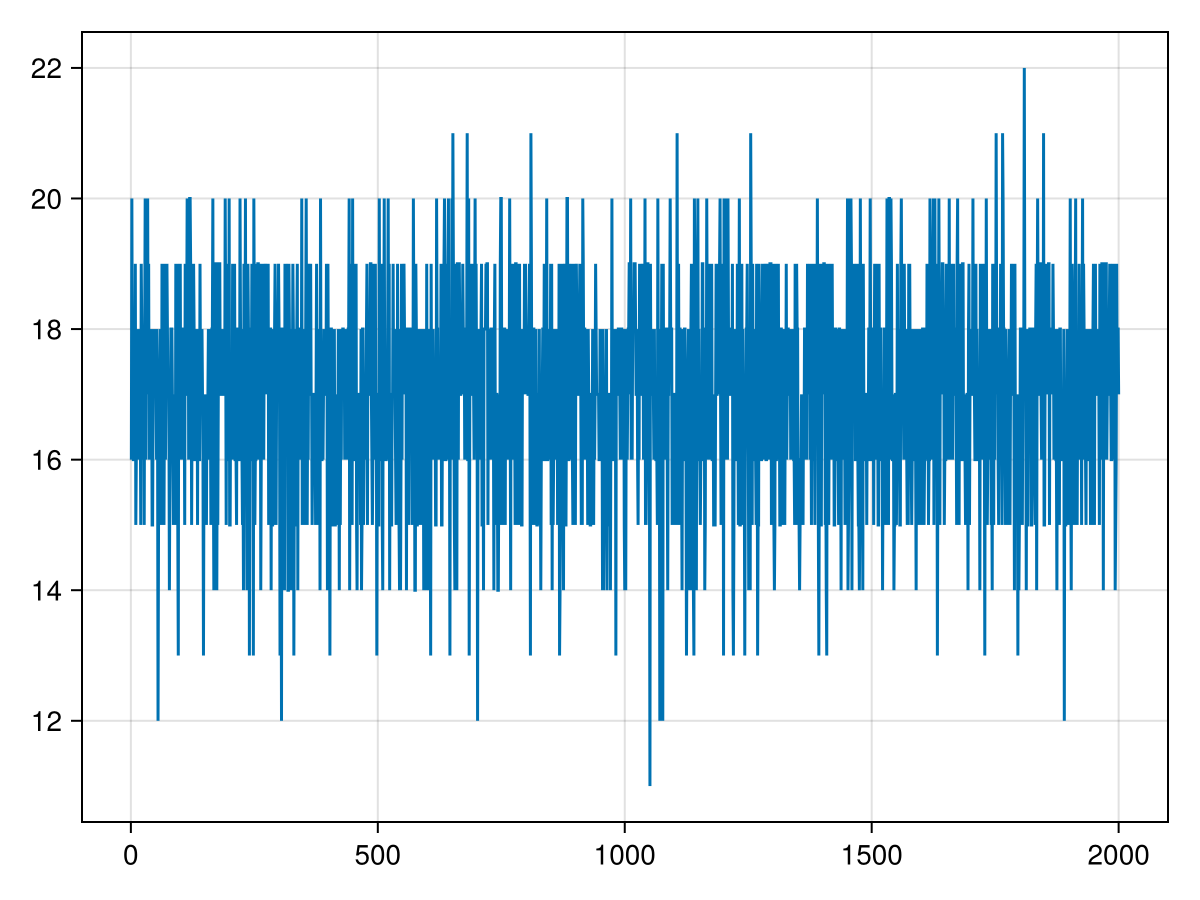

In [458]:
lines(sx)

In [463]:
for i in 1:0
    println(i)
end

In [449]:
using BenchmarkTools

In [424]:
L = 8
s = MixedDestabilizer(one(Stabilizer, L^2))
QuantumClifford.trusted_rank(s)

64

In [347]:
calc_EE(s, 1:Int(L/2), L, "x")

0

In [268]:
XX,YY,ZZ = create_operators(L)

(PauliOperator[+ XX______________________________________________________________ + ________XX______________________________________________________ … + ________________________________________________XX______________ + ________________________________________________________XX______; + _XX_____________________________________________________________ + _________XX_____________________________________________________ … + _________________________________________________XX_____________ + _________________________________________________________XX_____; … ; + ______XX________________________________________________________ + ______________XX________________________________________________ … + ______________________________________________________XX________ + ______________________________________________________________XX; + X______X________________________________________________________ + ________X______X________________________________________________ … + ______________________________

In [277]:
for xi in 1:L
    for yi in 1:Int(L)
        project!(s, XX[xi,yi], keep_result=false, phases=false)
    end
end

BoundsError: BoundsError: attempt to access 8×4 Matrix{PauliOperator} at index [1, 5]

In [257]:
for xi in 1:L
    for yi in 1:Int(L)
        project!(s, YY[xi,yi], keep_result=false, phases=false)
    end
end

In [435]:
ee = []
tmi = []
for n in 1:10000

    push!(ee,calc_EE(s, 1:Int(L / 2), L, "x"))
    push!(tmi,TMI(s, L, "x"))
    for i in 1:L
        for j in 1:L
            xi = rand(1:L)
            if rand() > 0.5
                yi = rand(1:Int(L / 2))
                project!(s, ZZ[xi, yi], keep_result=false, phases=false)
            else
                yi = rand(1:L)
                project!(s, XX[xi, yi], keep_result=false, phases=false)
            end
        end
    end
    push!(ee,calc_EE(s, 1:Int(L / 2), L, "x"))
    push!(tmi,TMI(s, L, "x"))
    for i in 1:500
        for i in 1:L
            for j in 1:L
                xi = rand(1:L)
                if rand() > 0.9
                    yi = rand(1:Int(L / 2))
                    project!(s, ZZ[xi, yi], keep_result=false, phases=false)
                else
                    yi = rand(1:L)
                    project!(s, XX[xi, yi], keep_result=false, phases=false)
                end
            end
        end
    end
end

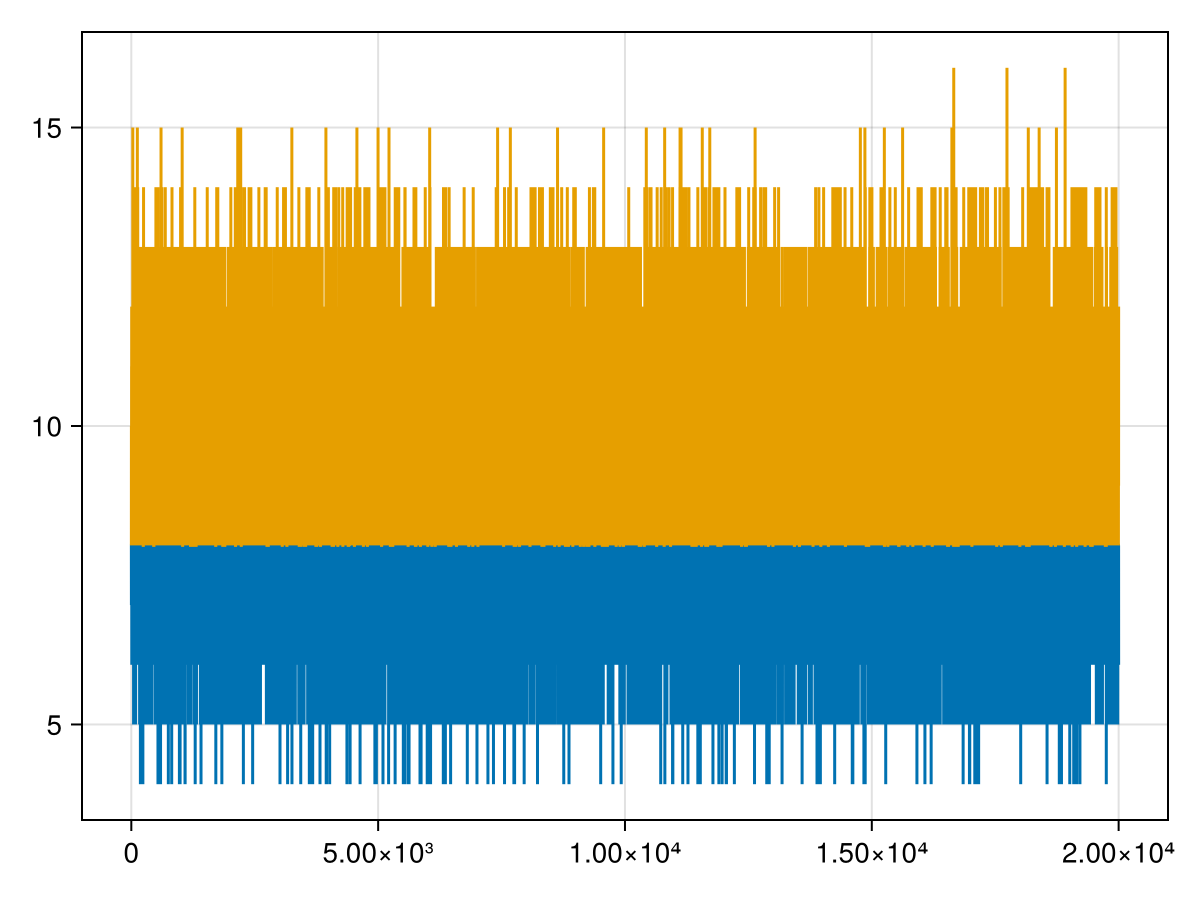

In [436]:
fig = Figure()
ax = Axis(fig[1,1])

lines!(ax, tmi)
lines!(ax, ee)

fig

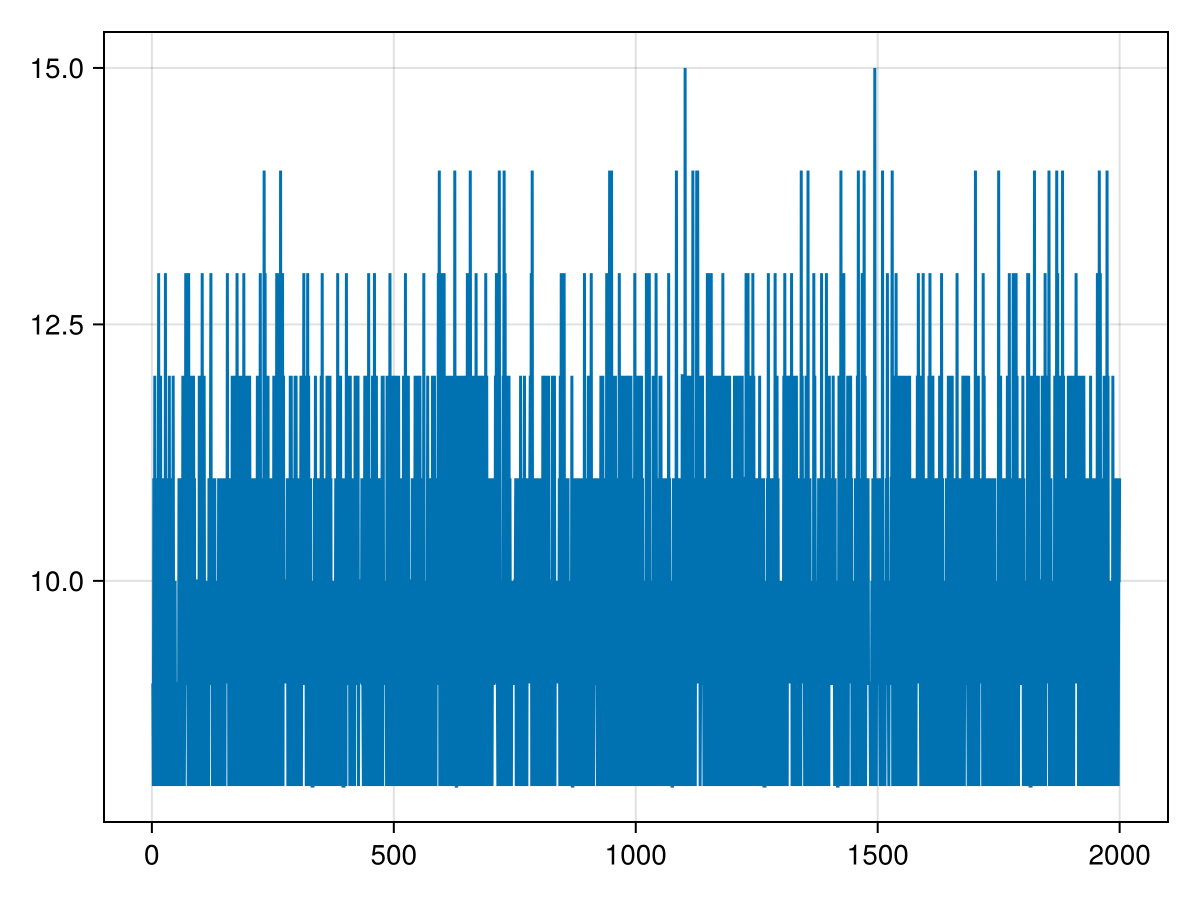

In [430]:
lines(ee)

In [337]:
QuantumClifford.trusted_rank(s)

60

In [326]:
1:L/2

1.0:1.0:4.0

In [330]:
calc_EE(s, 1:Int(L/2), L, "x")

11

In [331]:
TMI(s,L,"x")

5

In [302]:
mean(sx)

17.010309375

In [106]:
mean(sx)

18.05349375

In [443]:
msx = rollmean(tmi, 5000);

In [444]:
std(msx)

0.010407801430679164

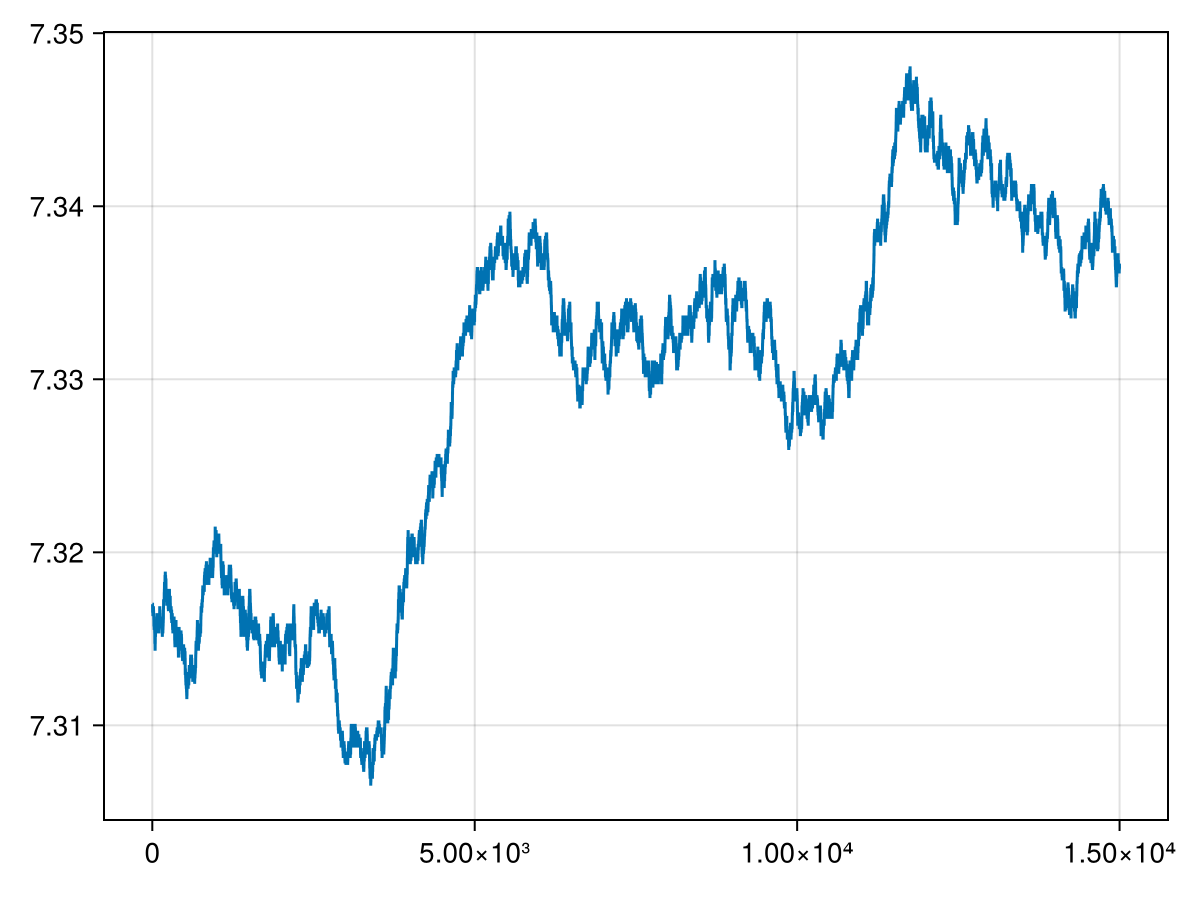

In [445]:
lines(msx)

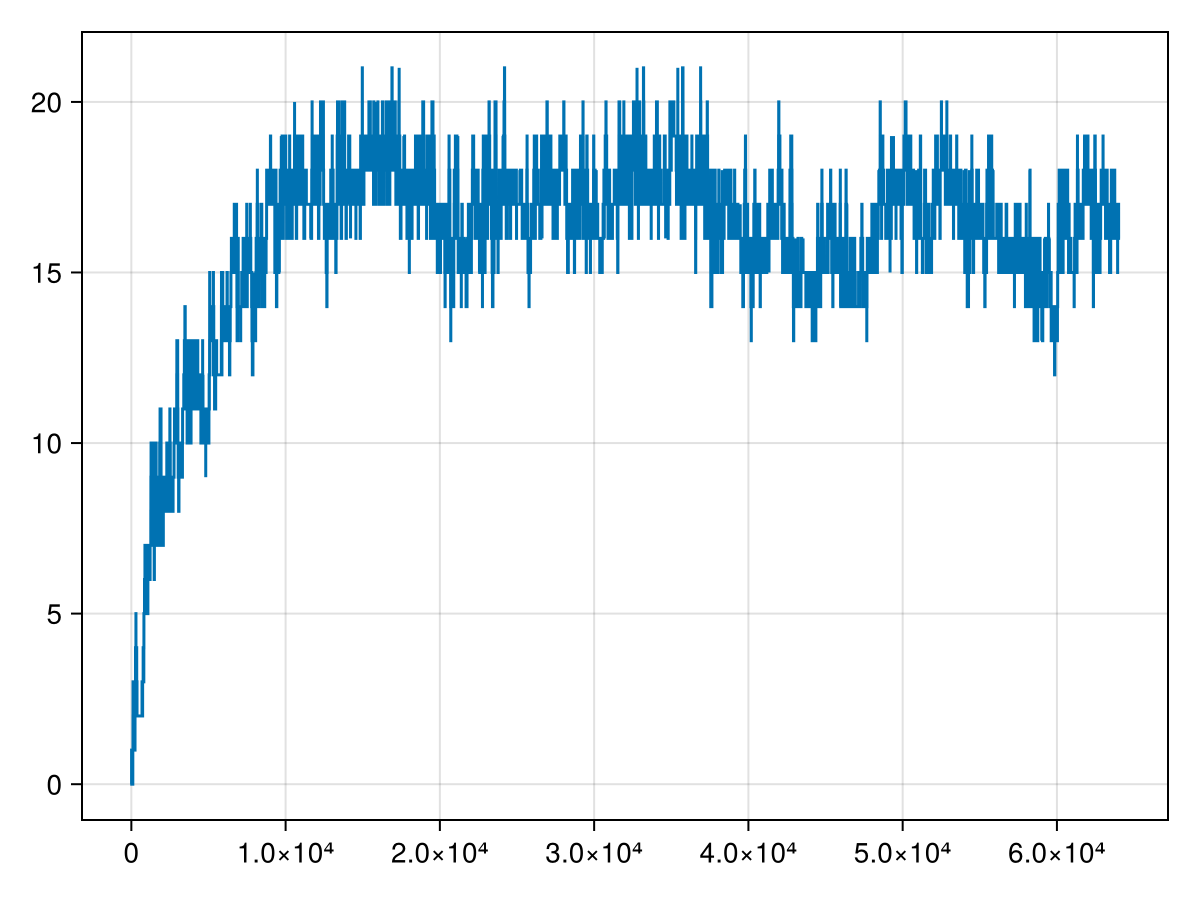

In [99]:
lines(sx)

In [88]:
pt = [0.1,0.2,0.7]

main(pt, 8, check = true)

trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Rank = 64
trusted Ra

(16.715078125, 11.511015625, -8.924609375, -7.021171875)

In [59]:
maximum(data_8[:,3])

8.0

In [97]:
## load data

data_12_mean = readdlm("data/initializations_L12_p_meanvar_SxSyTxTyr.txt")
data_12_zero = readdlm("data/initializations_L12_zero_p_meanvar_SxSyTxTyr.txt")
#data_12_prepared = readdlm("data/initializations_L12_prepared_p_meanvar_SxSyTxTyr.txt")

data_24_zero = readdlm("data/initializations_L24_zero_p_meanvar_SxSyTxTyr.txt")
data_24_prepared = readdlm("data/initializations_L24_prepared_p_meanvar_SxSyTxTyr.txt")
data_24_mean = readdlm("data/initializations_L24_p_meanvar_SxSyTxTyr.txt")

data_36_zero = readdlm("data/initializations_L36_zero_p_meanvar_SxSyTxTyr.txt")
data_36_prepared = readdlm("data/initializations_L36_prepared_p_meanvar_SxSyTxTyr.txt")
data_36_mean = readdlm("data/initializations_L36_p_meanvar_SxSyTxTyr.txt")

data_48_mean = readdlm("data/initializations_L48_p_meanvar_SxSyTxTyr.txt")
data_48_zero = readdlm("data/initializations_L48_zero_p_meanvar_SxSyTxTyr.txt")
data_48_prepared = readdlm("data/initializations_L48_prepared_p_meanvar_SxSyTxTyr.txt")

27×11 Matrix{Float64}:
 1.0   48.0     0.0          0.0     …  48.0  0.0  0.0  0.0  2304.0  0.0
 0.99  48.001   0.0009995    0.249      48.0  0.0  0.0  0.0  2304.0  0.0
 0.98  48.0015  0.0014985    0.495      48.0  0.0  0.0  0.0  2304.0  0.0
 0.97  48.007   0.00695448   0.792      48.0  0.0  0.0  0.0  2304.0  0.0
 0.96  48.0105  0.0103949    1.0175     48.0  0.0  0.0  0.0  2304.0  0.0
 0.95  48.0215  0.0220488    1.2935  …  48.0  0.0  0.0  0.0  2304.0  0.0
 0.94  48.023   0.0224822    1.532      48.0  0.0  0.0  0.0  2304.0  0.0
 0.93  48.037   0.0366493    1.8565     48.0  0.0  0.0  0.0  2304.0  0.0
 0.92  48.046   0.0469075    2.195      48.0  0.0  0.0  0.0  2304.0  0.0
 0.91  48.074   0.0785633    2.4875     48.0  0.0  0.0  0.0  2304.0  0.0
 ⋮                                   ⋱   ⋮                           ⋮
 0.82  48.3305  0.336438     5.851      48.0  0.0  0.0  0.0  2304.0  0.0
 0.81  48.3895  0.409995     6.2965     48.0  0.0  0.0  0.0  2304.0  0.0
 0.8   48.4415  0.440798     6

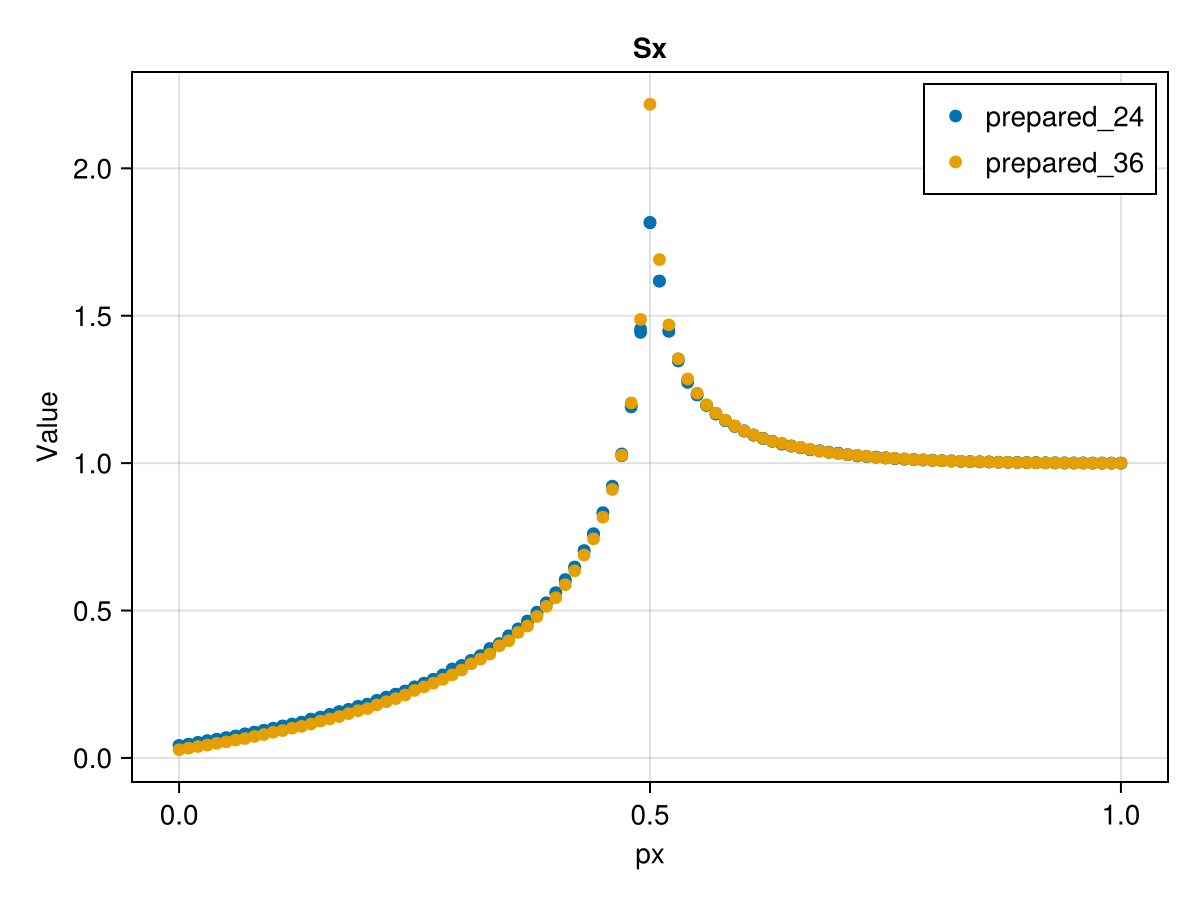

In [106]:
f = Figure()
ax = Axis(f[1, 1],
    title = "Sx",
    xlabel = "px",
    ylabel = "Value",
)
# plot!(ax,data_12_mean[:,1], data_12_mean[:,2]./12, label = "mixed_12")
# plot!(ax,data_12_zero[:,1], data_12_zero[:,2]./12, label = "zero_12")
# plot!(ax,data_24_mean[:,1], data_24_mean[:,2]./24, label = "mixed_24")
# plot!(ax,data_24_zero[:,1], data_24_zero[:,2]./24, label = "zero_24")
plot!(ax,data_24_prepared[:,1], data_24_prepared[:,2]./24, label = "prepared_24")
# plot!(ax,data_36_mean[:,1], data_36_mean[:,2]./36, label = "mixed_36")
# plot!(ax,data_36_zero[:,1], data_36_zero[:,2]./36, label = "zero_36")
plot!(ax,data_36_prepared[:,1], data_36_prepared[:,2]./36, label = "prepared_36")
axislegend(position = :rt)
#save("plots/Sx_zero.png", f)
f

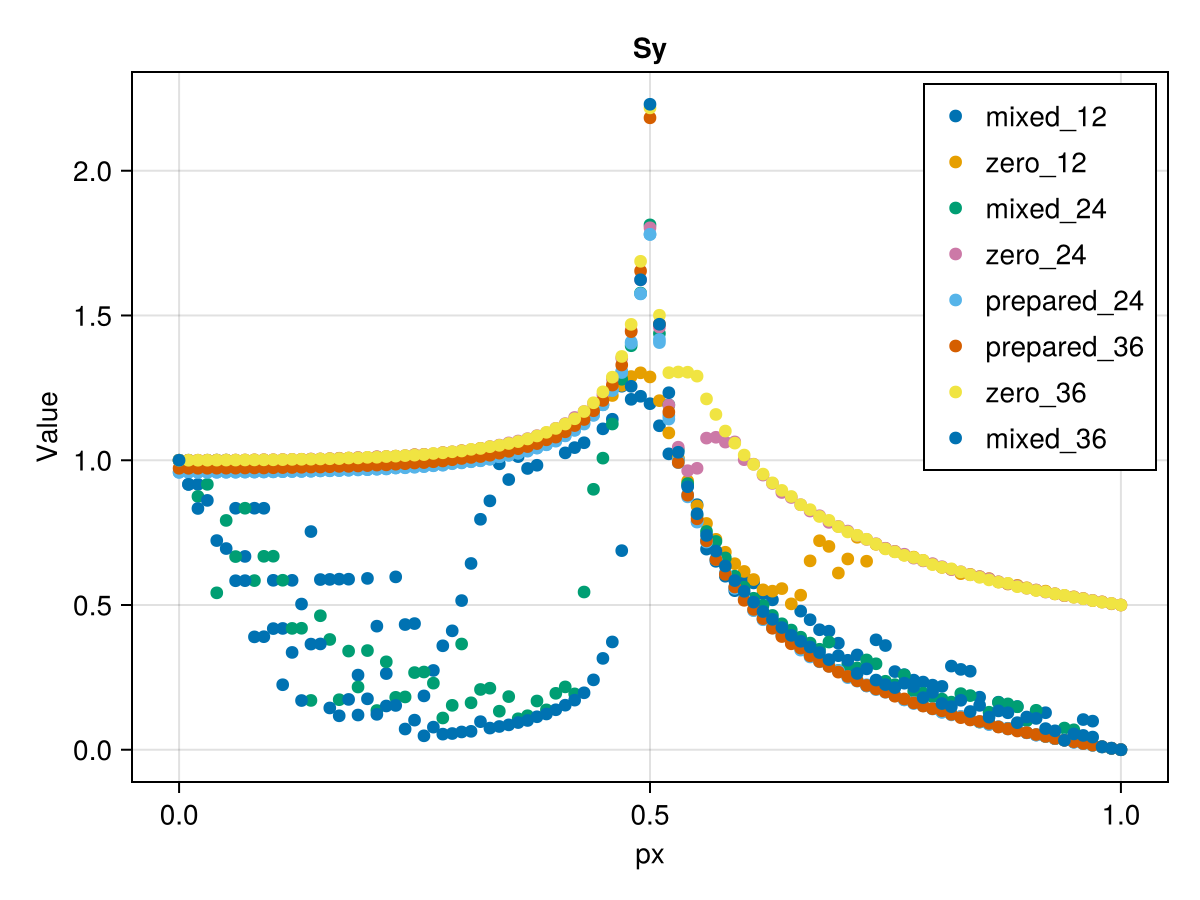

In [107]:
f = Figure()
ax = Axis(f[1, 1],
    title = "Sy",
    xlabel = "px",
    ylabel = "Value",
)
plot!(ax,data_12_mean[:,1], data_12_mean[:,4]./12,label = "mixed_12")
plot!(ax,data_12_zero[:,1], data_12_zero[:,4]./12, label = "zero_12")
plot!(ax,data_24_mean[:,1], data_24_mean[:,4]./24, label = "mixed_24")
plot!(ax,data_24_zero[:,1], data_24_zero[:,4]./24, label = "zero_24")
plot!(ax,data_24_prepared[:,1], data_24_prepared[:,4]./24, label = "prepared_24")
plot!(ax,data_36_prepared[:,1], data_36_prepared[:,4]./36, label = "prepared_36")
plot!(ax,data_36_zero[:,1], data_36_zero[:,4]./36, label = "zero_36")
plot!(ax,data_36_mean[:,1], data_36_mean[:,4]./36, label = "mixed_36")

axislegend(position = :rt)
# save("plots/Sy.png", f)
f

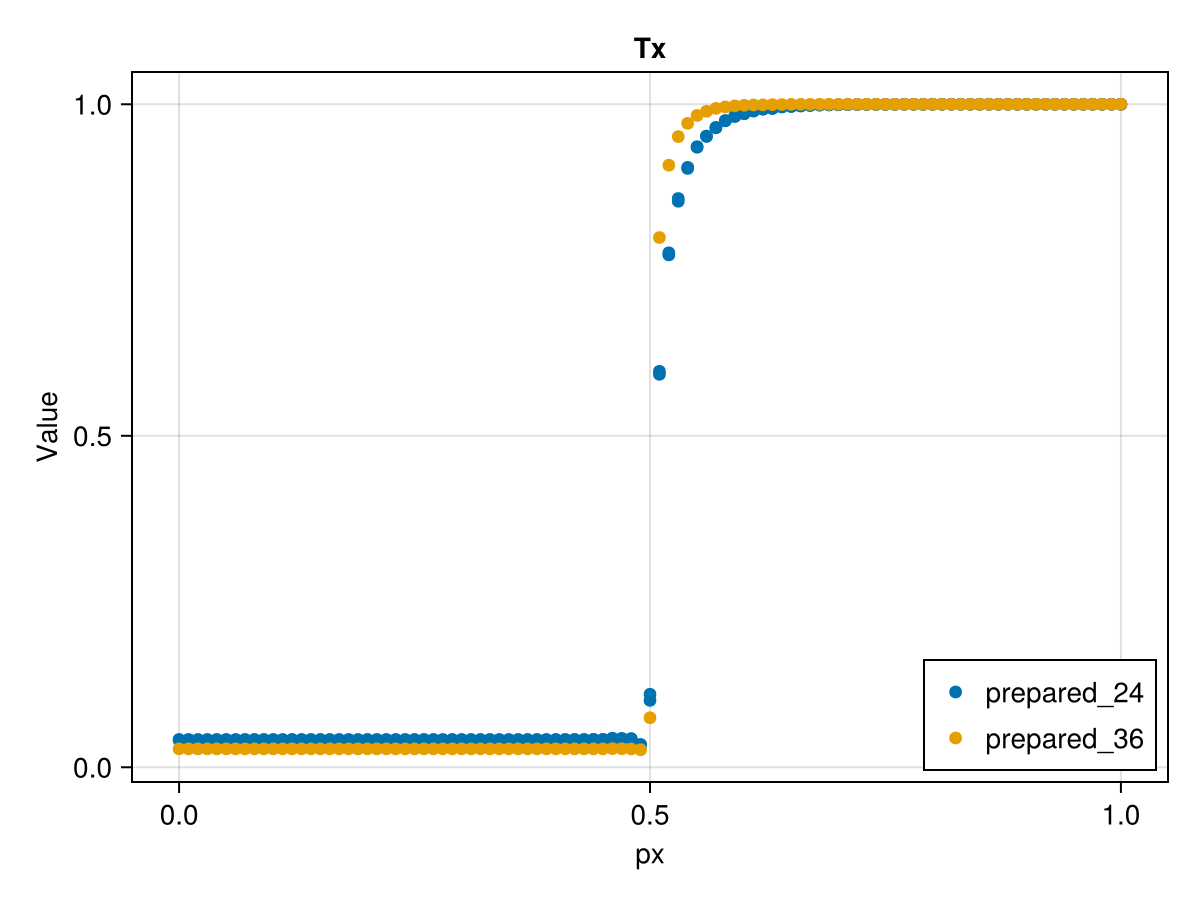

In [115]:
f = Figure()
ax = Axis(f[1, 1],
    title = "Tx",
    xlabel = "px",
    ylabel = "Value",
)
# plot!(ax,data_12_mean[:,1], data_12_mean[:,6]./12, label = "mixed_12")
# plot!(ax,data_12_zero[:,1], data_12_zero[:,6]./12, label = "zero_12")
plot!(ax,data_24_prepared[:,1], data_24_prepared[:,6]./24, label = "prepared_24")
# plot!(ax,data_24_zero[:,1], data_24_zero[:,6]./24, label = "zero_24")
# plot!(ax,data_24_mean[:,1], data_24_mean[:,6]./24, label = "mixed_24")
plot!(ax,data_36_prepared[:,1], data_36_prepared[:,6]./36, label = "prepared_36")
# plot!(ax,data_36_zero[:,1], data_36_zero[:,6]./36, label = "zero_36")
# plot!(ax,data_36_mean[:,1], data_36_mean[:,6]./36, label = "mixed_36")
axislegend(position = :rb)
#save("plots/Tx_prepared.png", f)
f

In [ ]:
#plot!(ax,data_12_mean[:,1], data_12_mean[:,6]./12, label = "mixed_12")
#plot!(ax,data_12_zero[:,1], data_12_zero[:,6]./12, label = "zero_12")
#plot!(ax,data_24_prepared[:,1], data_24_prepared[:,6]./24, label = "prepared_24")
#plot!(ax,data_24_zero[:,1], data_24_zero[:,6]./24, label = "zero_24")
#plot!(ax,data_24_mean[:,1], data_24_mean[:,6]./24, label = "mixed_24")
#plot!(ax,data_36_prepared[:,1], data_36_prepared[:,6]./36, label = "prepared_36")
#plot!(ax,data_36_zero[:,1], data_36_zero[:,6]./36, label = "zero_36")
plot!(ax,data_36_mean[:,1], data_36_mean[:,6]./36, label = "mixed_36")
axislegend(position = :rb)
f

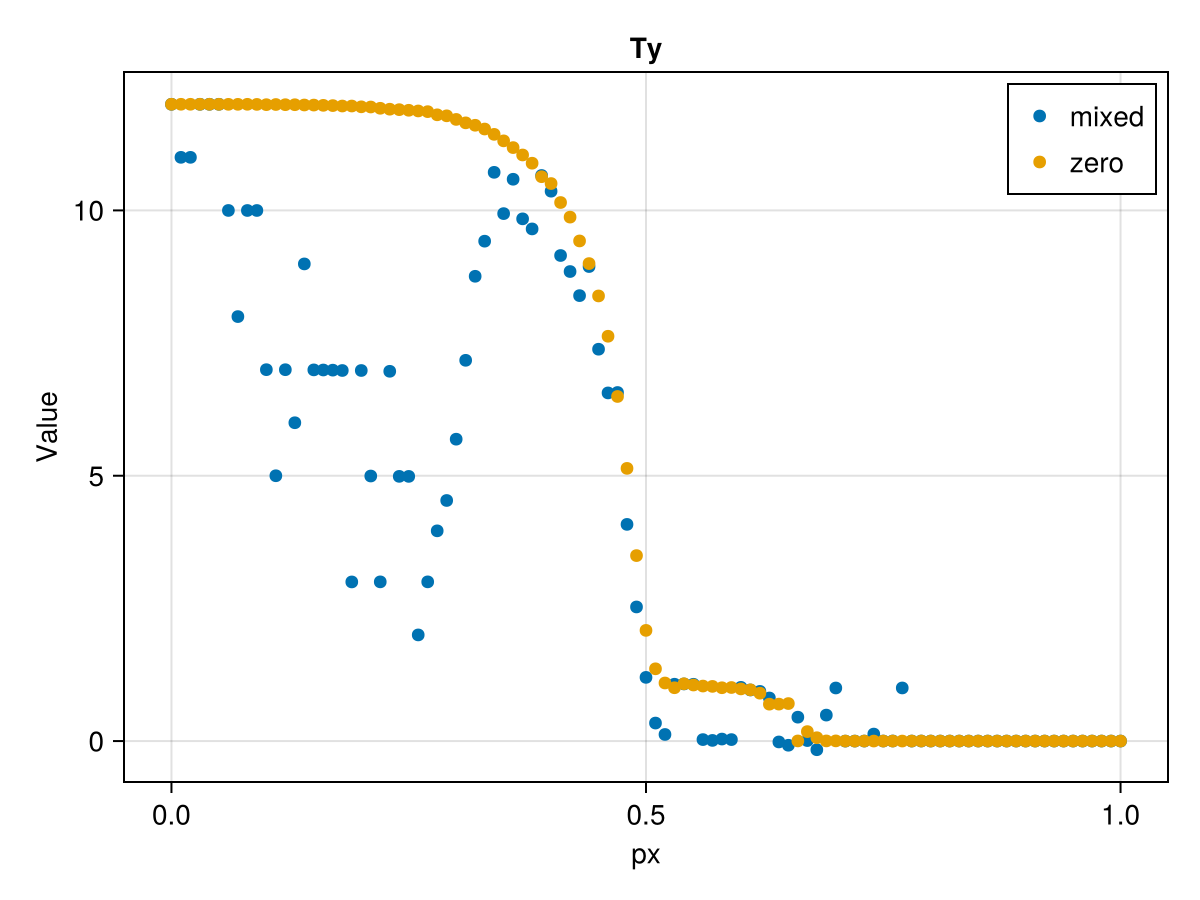

In [44]:
f = Figure()
ax = Axis(f[1, 1],
    title = "Ty",
    xlabel = "px",
    ylabel = "Value",
)
plot!(ax,data_12_mean[:,1], data_12_mean[:,8], label = "mixed")
plot!(ax,data_12_zero[:,1], data_12_zero[:,8], label = "zero")
axislegend(position = :rt)
f

In [77]:
data_24_zero = readdlm("data/initializations_L24_zero_p_meanvar_SxSyTxTyr.txt")
data_24_prepared = readdlm("data/initializations_L24_prepared_p_meanvar_SxSyTxTyr.txt")
data_24_mean = readdlm("data/initializations_L24_p_meanvar_SxSyTxTyr.txt")

data_36_zero = readdlm("data/initializations_L36_zero_p_meanvar_SxSyTxTyr.txt")
data_36_prepared = readdlm("data/initializations_L36_prepared_p_meanvar_SxSyTxTyr.txt")
data_36_mean = readdlm("data/initializations_L36_p_meanvar_SxSyTxTyr.txt")

68×11 Matrix{Float64}:
 1.0   36.0      0.0         0.0     …  36.0  0.0  0.0  0.0  1296.0  0.0
 0.99  33.001    0.0009995   0.1805     33.0  0.0  0.0  0.0  1296.0  0.0
 0.98  32.0005   0.0005      0.3725     32.0  0.0  0.0  0.0  1296.0  0.0
 0.97  26.004    0.00398599  1.5735     26.0  0.0  0.0  0.0  1296.0  0.0
 0.96  22.009    0.00892346  1.78       22.0  0.0  0.0  0.0  1296.0  0.0
 0.95  23.0145   0.0142969   1.9635  …  23.0  0.0  0.0  0.0  1296.0  0.0
 0.94  17.0195   0.0201298   1.173      17.0  0.0  0.0  0.0  1296.0  0.0
 0.93  17.023    0.0234827   2.353      17.0  0.0  0.0  0.0  1296.0  0.0
 0.92  17.0365   0.0361858   2.627      17.0  0.0  0.0  0.0  1296.0  0.0
 0.91  17.041    0.0393387   3.8915     17.0  0.0  0.0  0.0  1296.0  0.0
 ⋮                                   ⋱   ⋮                           ⋮
 0.41  21.125   17.225       5.5375      1.0  0.0  1.0  0.0  1296.0  0.0
 0.4   19.7395  17.2983      4.969   …   1.0  0.0  1.0  0.0  1296.0  0.0
 0.39  18.5175  15.9767      4

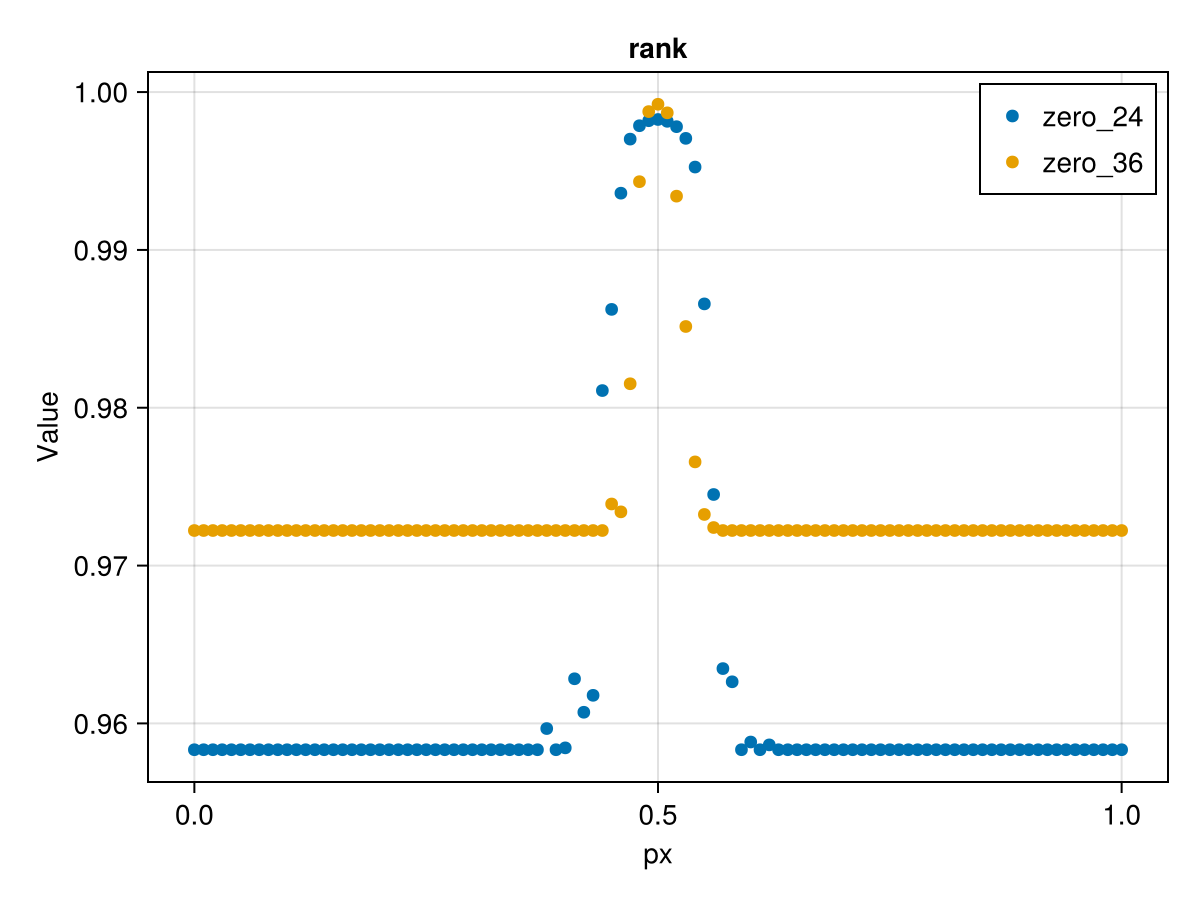

In [126]:
f = Figure()
ax = Axis(f[1, 1],
    title = "rank",
    xlabel = "px",
    ylabel = "Value",
)
plot!(ax,data_24_zero[:,1], data_24_zero[:,10]./24^2, label = "zero_24")
# plot!(ax,data_24_prepared[:,1], data_24_prepared[:,10]./24^2, label = "prepared")
# plot!(ax,data_24_mean[:,1], data_24_mean[:,10]./24^2, label = "mixed")
plot!(ax,data_36_zero[:,1], data_36_zero[:,10]./36^2, label = "zero_36")
# plot!(ax,data_36_prepared[:,1], data_36_prepared[:,10]./36^2, label = "prepared")
# plot!(ax,data_36_mean[:,1], data_36_mean[:,10]./36^2, label = "mixed")
axislegend(position = :rt)
save("plots/rank_zero.png", f)
f

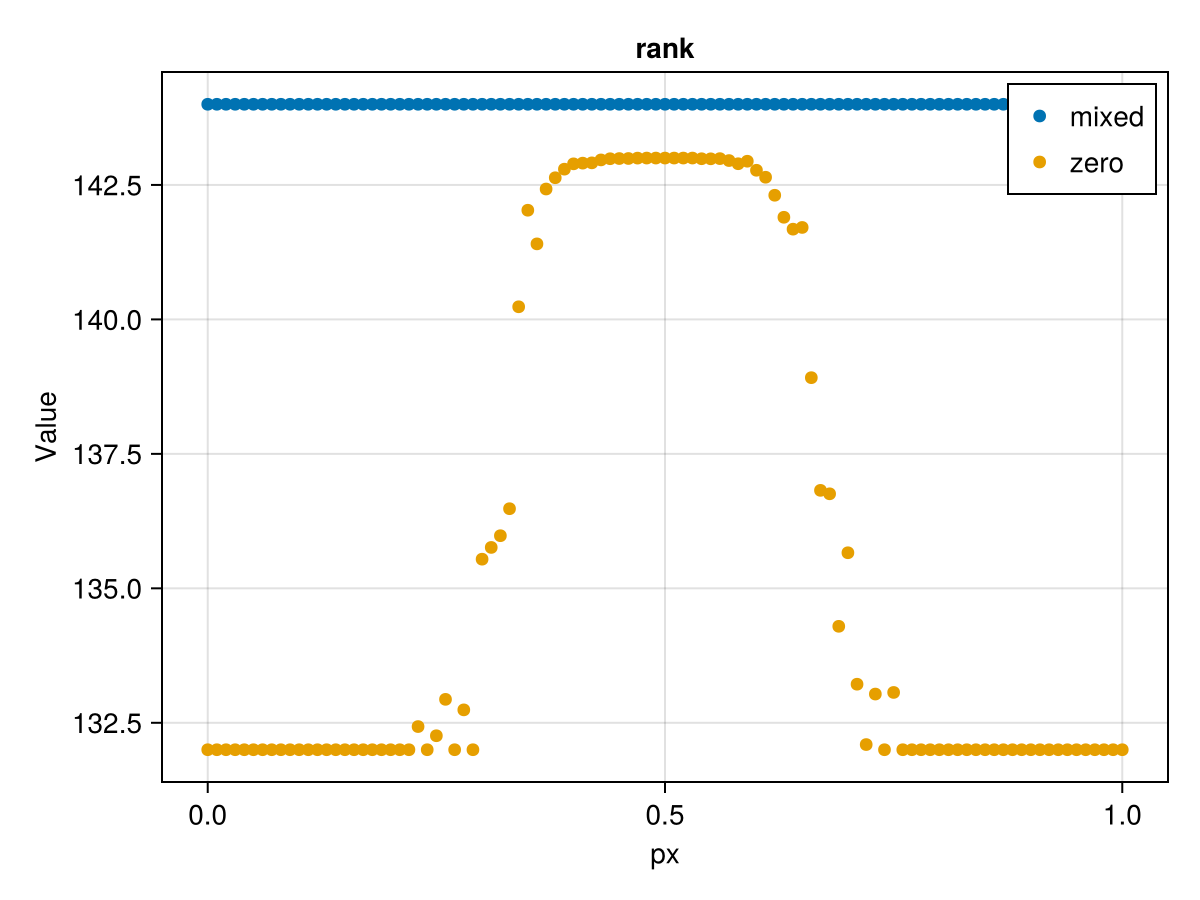

In [46]:
f = Figure()
ax = Axis(f[1, 1],
    title = "rank",
    xlabel = "px",
    ylabel = "Value",
)
plot!(ax,data_12_mean[:,1], data_12_mean[:,10], label = "mixed")
plot!(ax,data_12_zero[:,1], data_12_zero[:,10], label = "zero")
axislegend(position = :rt)
f

In [ ]:
plot(data_12_mean[:,1], data_12_mean[:,2], label = "Sx")

In [139]:
points2d = projection.([(x, y, z) for (x, y, z) in p]);

In [141]:
points2d

228-element Vector{Tuple{Float64, Float64}}:
 (0.7071067811865477, -0.408248290463863)
 (0.6363961030678928, -0.408248290463863)
 (0.565685424949238, -0.408248290463863)
 (0.4949747468305833, -0.40824829046386296)
 (0.42426406871192857, -0.408248290463863)
 (0.3535533905932738, -0.408248290463863)
 (0.282842712474619, -0.408248290463863)
 (0.2121320343559643, -0.408248290463863)
 (0.14142135623730948, -0.408248290463863)
 (0.0707106781186548, -0.408248290463863)
 ⋮
 (0.10606601717798211, 0.6327848502189877)
 (0.03535533905932739, 0.6327848502189877)
 (-0.03535533905932739, 0.6327848502189877)
 (-0.10606601717798214, 0.6327848502189877)
 (0.07071067811865475, 0.694022093788567)
 (0.0, 0.694022093788567)
 (0.03535533905932736, 0.7552593373581465)
 (-0.03535533905932736, 0.7552593373581465)
 (0.0, 0.816496580927726)

In [142]:
data_12_mean

101×11 Matrix{Float64}:
 1.0   12.0     0.0          0.0     …   0.0     0.0        144.0  0.0
 0.99  12.0005  0.0005       0.056       0.0     0.0        144.0  0.0
 0.98  12.0015  0.0014985    0.1255      0.0     0.0        144.0  0.0
 0.97  11.0035  0.00348949   1.185       0.0     0.0        144.0  0.0
 0.96   9.0035  0.00348949   1.2505      0.0     0.0        144.0  0.0
 0.95  11.0045  0.00448199   0.311   …   0.0     0.0        144.0  0.0
 0.94   7.007   0.00695448   0.3995      0.0     0.0        144.0  0.0
 0.93  11.012   0.0118619    0.4575      0.0     0.0        144.0  0.0
 0.92   8.013   0.0128374    1.534       0.0     0.0        144.0  0.0
 0.91  11.017   0.0167194    0.609       0.0     0.0        144.0  0.0
 ⋮                                   ⋱                             ⋮
 0.08   0.51    0.517159    10.0115      9.9985  0.0014985  144.0  0.0
 0.07   1.4725  0.489488     8.013       7.999   0.0009995  144.0  0.0
 0.06   0.405   0.423187    10.0095      9.999   0.0009

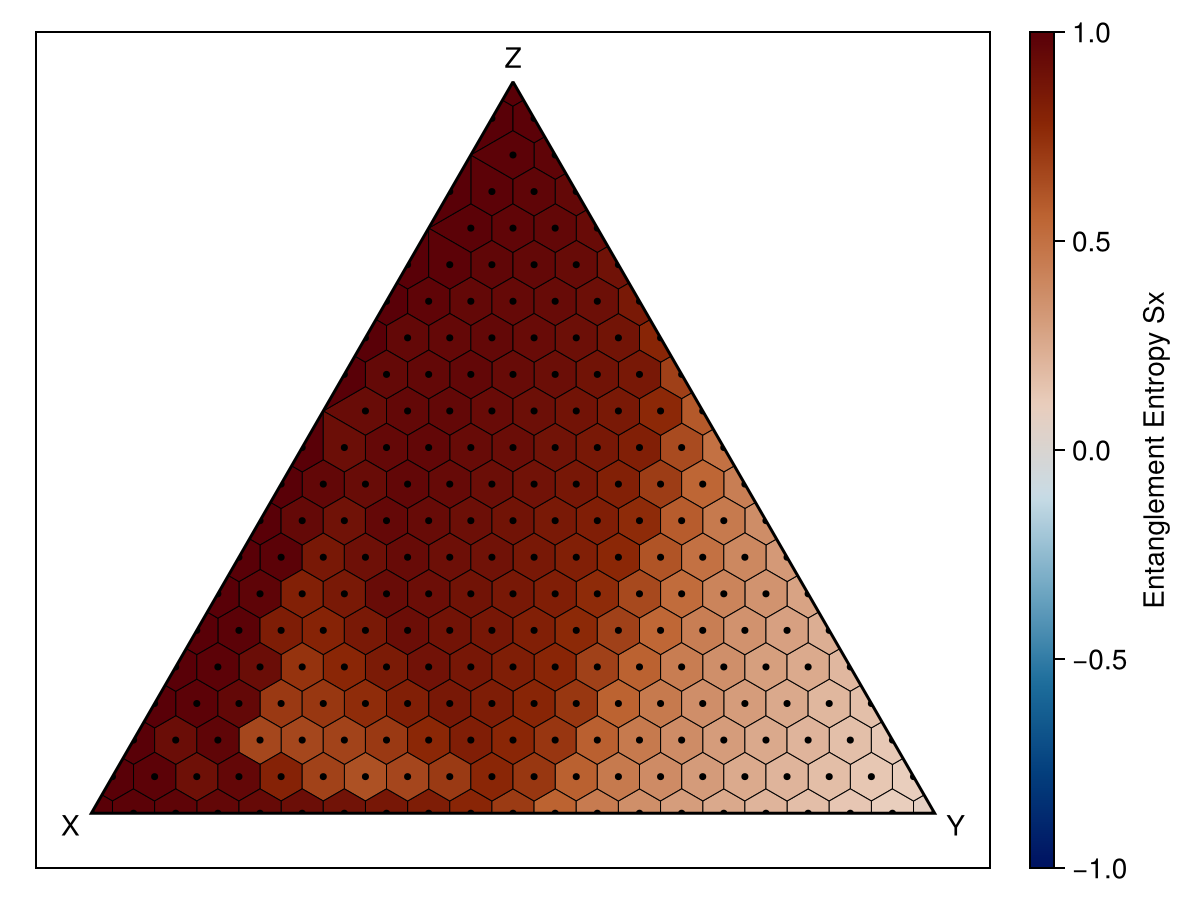

In [155]:
fig = Figure()
ax = Axis(fig[1, 1], aspect=DataAspect())
hidedecorations!(ax)
voronoiplot!(
    ax,
    #rand(10), rand(10), rand(10),
    [p[1] for p in points2d],
    [p[2] for p in points2d],
    Sx./12 .|> Float64,
    colormap=:vik10,
    markersize=5,
    strokewidth=0.5,
    unbounded_edge_extension_factor=1.0,
    colorrange=(-1, 1),
    highclip=:white,
    lowclip=:white,
    nan_color=:black
)
p = CairoMakie.Polygon(
    Point2f[(-0.8, -0.5), (0.8, -0.5), (0.8, 0.9), (-0.8, 0.9)],
    [Point2f[
        projection([1, 0, 0]),
        projection([0, 1, 0]),
        projection([0, 0, 1])
    ]]
)
poly!(p, color=:white)
lines!(ax, [
        projection([1, 0, 0]),
        projection([0, 1, 0]),
        projection([0, 0, 1]),
        projection([1, 0, 0])], color=:black)
#lines!(ax, [norm(projection([0.5, 0.5, 0])) * cos(t) for t in range(0, 2π, length=100)], [norm(projection([0.5, 0.5, 0])) * sin(t) for t in range(0, 2π, length=100)], color=:red, linewidth=2)
text!(ax, Point2f[projection([1.05, 0, 0]), projection([0, 1.05, 0]), projection([0, 0, 1.05])], text=["X", "Y", "Z"], color=:black, align=(:center, :center))
limits!(ax, (-0.8, 0.8), (-0.5, 0.9))
Colorbar(fig[1, 2], limits=(-1, 1), colormap=:vik10,
    flipaxis=true, label="Entanglement Entropy Sx")
save("plots/triangular/Sx_L12.png", fig)
fig

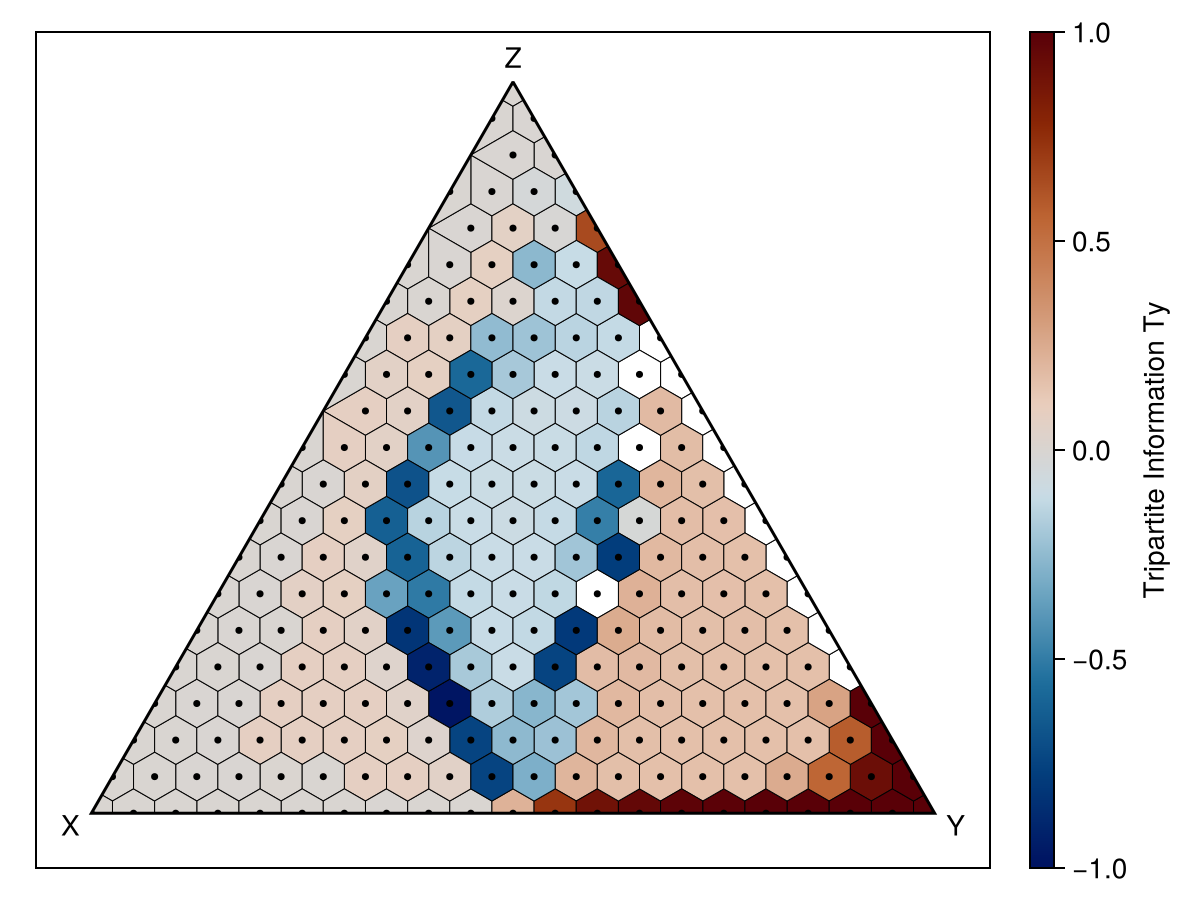

In [156]:
fig = Figure()
ax = Axis(fig[1, 1], aspect=DataAspect())
hidedecorations!(ax)
voronoiplot!(
    ax,
    #rand(10), rand(10), rand(10),
    [p[1] for p in points2d],
    [p[2] for p in points2d],
    Ty./12 .|> Float64,
    colormap=:vik10,
    markersize=5,
    strokewidth=0.5,
    unbounded_edge_extension_factor=1.0,
    colorrange=(-1, 1),
    highclip=:white,
    lowclip=:white,
    nan_color=:black
)
p = CairoMakie.Polygon(
    Point2f[(-0.8, -0.5), (0.8, -0.5), (0.8, 0.9), (-0.8, 0.9)],
    [Point2f[
        projection([1, 0, 0]),
        projection([0, 1, 0]),
        projection([0, 0, 1])
    ]]
)
poly!(p, color=:white)
lines!(ax, [
        projection([1, 0, 0]),
        projection([0, 1, 0]),
        projection([0, 0, 1]),
        projection([1, 0, 0])], color=:black)
#lines!(ax, [norm(projection([0.5, 0.5, 0])) * cos(t) for t in range(0, 2π, length=100)], [norm(projection([0.5, 0.5, 0])) * sin(t) for t in range(0, 2π, length=100)], color=:red, linewidth=2)
text!(ax, Point2f[projection([1.05, 0, 0]), projection([0, 1.05, 0]), projection([0, 0, 1.05])], text=["X", "Y", "Z"], color=:black, align=(:center, :center))
limits!(ax, (-0.8, 0.8), (-0.5, 0.9))
Colorbar(fig[1, 2], limits=(-1, 1), colormap=:vik10,
    flipaxis=true, label="Tripartite Information Ty")
save("plots/triangular/Ty_L12.png", fig)

fig

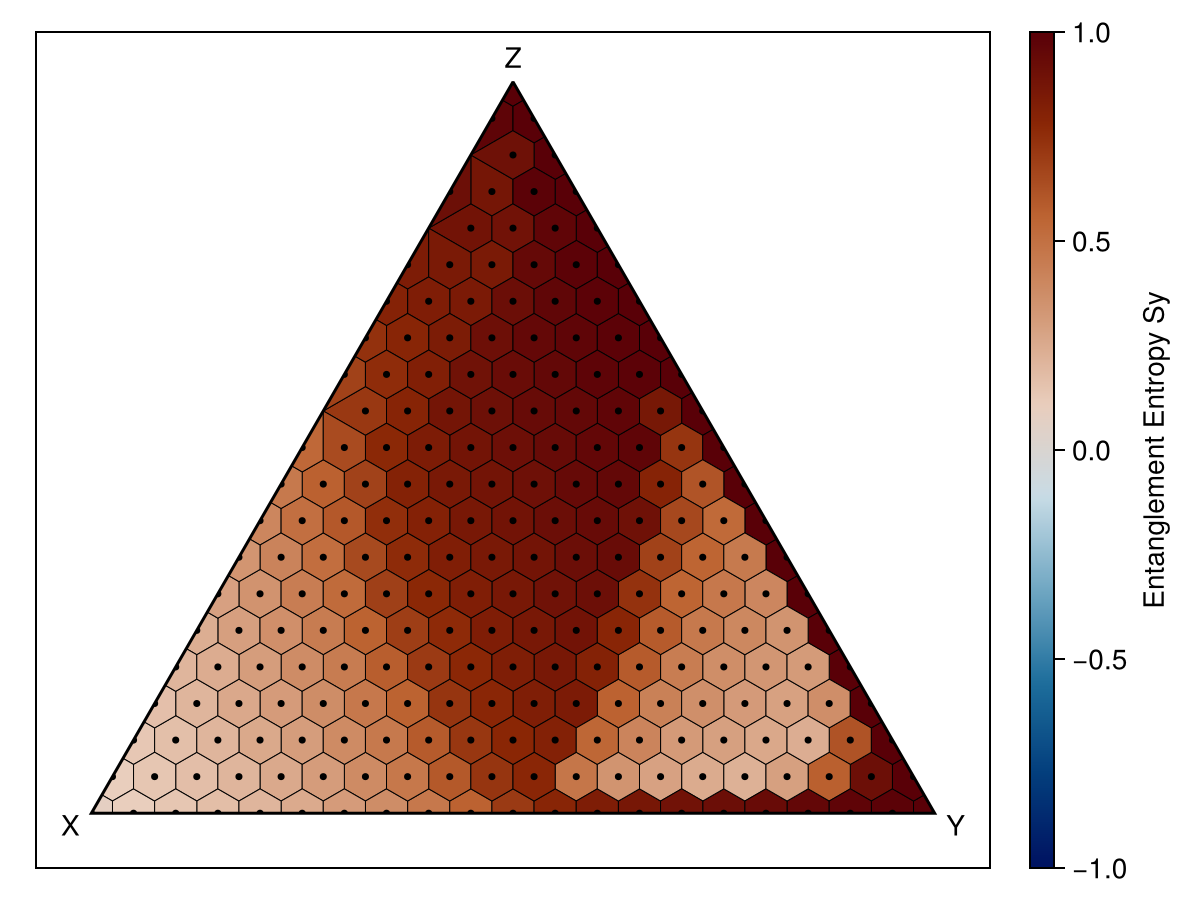

In [157]:
fig = Figure()
ax = Axis(fig[1, 1], aspect=DataAspect())
hidedecorations!(ax)
voronoiplot!(
    ax,
    #rand(10), rand(10), rand(10),
    [p[1] for p in points2d],
    [p[2] for p in points2d],
    Sy./12 .|> Float64,
    colormap=:vik10,
    markersize=5,
    strokewidth=0.5,
    unbounded_edge_extension_factor=1.0,
    colorrange=(-1, 1),
    highclip=:white,
    lowclip=:white,
    nan_color=:black
)
p = CairoMakie.Polygon(
    Point2f[(-0.8, -0.5), (0.8, -0.5), (0.8, 0.9), (-0.8, 0.9)],
    [Point2f[
        projection([1, 0, 0]),
        projection([0, 1, 0]),
        projection([0, 0, 1])
    ]]
)
poly!(p, color=:white)
lines!(ax, [
        projection([1, 0, 0]),
        projection([0, 1, 0]),
        projection([0, 0, 1]),
        projection([1, 0, 0])], color=:black)
#lines!(ax, [norm(projection([0.5, 0.5, 0])) * cos(t) for t in range(0, 2π, length=100)], [norm(projection([0.5, 0.5, 0])) * sin(t) for t in range(0, 2π, length=100)], color=:red, linewidth=2)
text!(ax, Point2f[projection([1.05, 0, 0]), projection([0, 1.05, 0]), projection([0, 0, 1.05])], text=["X", "Y", "Z"], color=:black, align=(:center, :center))
limits!(ax, (-0.8, 0.8), (-0.5, 0.9))
Colorbar(fig[1, 2], limits=(-1, 1), colormap=:vik10,
    flipaxis=true, label="Entanglement Entropy Sy")

save("plots/triangular/Sy_L12.png", fig)

fig

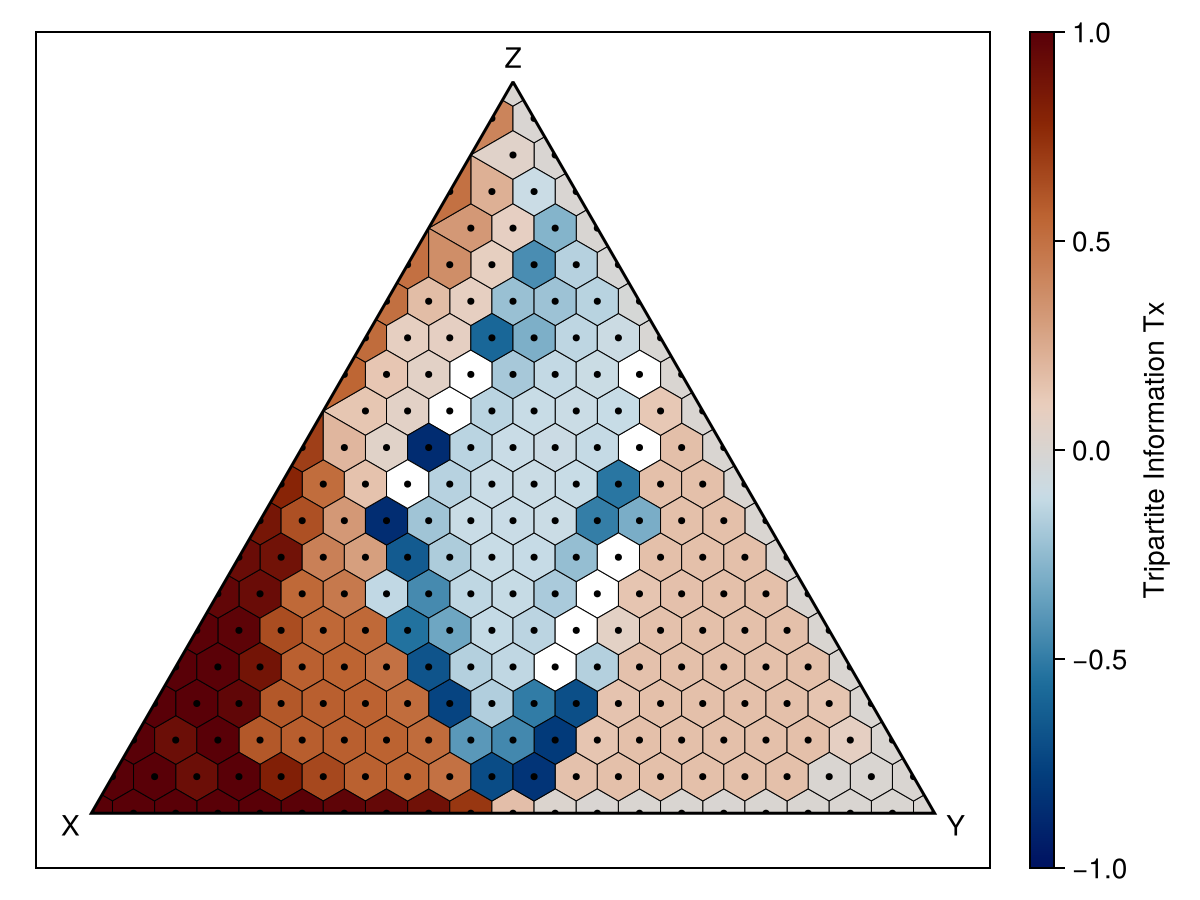

In [158]:
fig = Figure()
ax = Axis(fig[1, 1], aspect=DataAspect())
hidedecorations!(ax)
voronoiplot!(
    ax,
    #rand(10), rand(10), rand(10),
    [p[1] for p in points2d],
    [p[2] for p in points2d],
    Tx./12 .|> Float64,
    colormap=:vik10,
    markersize=5,
    strokewidth=0.5,
    unbounded_edge_extension_factor=1.0,
    colorrange=(-1, 1),
    highclip=:white,
    lowclip=:white,
    nan_color=:black
)
p = CairoMakie.Polygon(
    Point2f[(-0.8, -0.5), (0.8, -0.5), (0.8, 0.9), (-0.8, 0.9)],
    [Point2f[
        projection([1, 0, 0]),
        projection([0, 1, 0]),
        projection([0, 0, 1])
    ]]
)
poly!(p, color=:white)
lines!(ax, [
        projection([1, 0, 0]),
        projection([0, 1, 0]),
        projection([0, 0, 1]),
        projection([1, 0, 0])], color=:black)
#lines!(ax, [norm(projection([0.5, 0.5, 0])) * cos(t) for t in range(0, 2π, length=100)], [norm(projection([0.5, 0.5, 0])) * sin(t) for t in range(0, 2π, length=100)], color=:red, linewidth=2)
text!(ax, Point2f[projection([1.05, 0, 0]), projection([0, 1.05, 0]), projection([0, 0, 1.05])], text=["X", "Y", "Z"], color=:black, align=(:center, :center))
limits!(ax, (-0.8, 0.8), (-0.5, 0.9))
Colorbar(fig[1, 2], limits=(-1, 1), colormap=:vik10,
    flipaxis=true, label="Tripartite Information Tx")

save("plots/triangular/Tx_L12.png", fig)

fig

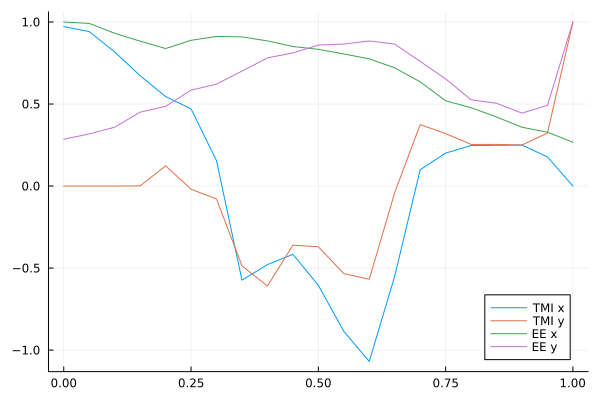

In [192]:
Plots.plot(px, T1_2./L, label = "TMI x")
Plots.plot!(px,T2_2./L, label = "TMI y")
Plots.plot!(px,S1_2./L, label = "EE x")
Plots.plot!(px,S2_2./L, label = "EE y")

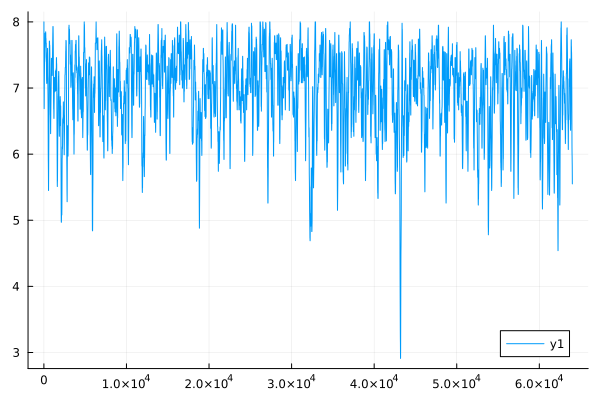

In [66]:
Plots.plot(runmean(S, 100))

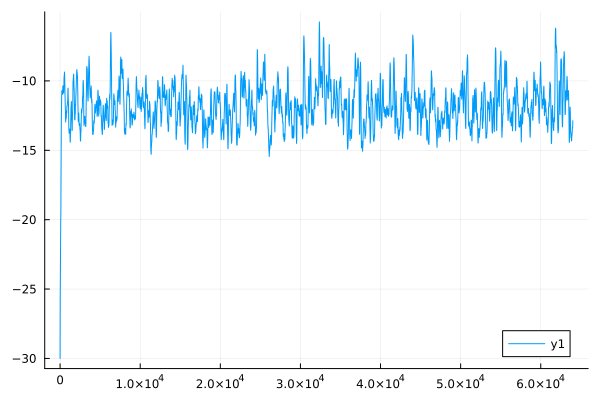

In [67]:
Plots.plot(runmean(T, 100))